## Description

This kernel is a continuation of my previous kernels and is aimed at creating a huge number of features, which were invented in different public kernels (including mine). Please notice, that high number of available features doesn't mean that using all of them at once is a good idea :) Feature selection should be used to limit the number of features.

Another important point: some of the code for feature creation is commented, because otherwise kernel hits time limit. I generated these features locally and created a dataset with them: https://www.kaggle.com/artgor/lanl-features

Also I wrote another kernel to show various model interpretation and feature selection technics: https://www.kaggle.com/artgor/feature-selection-model-interpretation-and-more

Importing libraries.

In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
from scipy import stats
from sklearn.kernel_ridge import KernelRidge
from itertools import product

from tsfresh.feature_extraction import feature_calculators
from joblib import Parallel, delayed

## Feature generation

At first I want to aknowledge these kernels and use features/ideas from them:
* fft features from  https://www.kaggle.com/gpreda/lanl-earthquake-eda-and-prediction
* some changes to code of feature generation inspired by https://www.kaggle.com/arkaung/earthquakes-over-feature-engineering-lightgbm
* tsfresh and some other features from https://www.kaggle.com/abhishek/quite-a-few-features-1-51/data I also use the class from this kernel, it is really great!

## Preparing functions

In [2]:
# Create a training file with simple derived features

def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

def classic_sta_lta(x, length_sta, length_lta):
    
    sta = np.cumsum(x ** 2)

    # Convert to float
    sta = np.require(sta, dtype=np.float)

    # Copy for LTA
    lta = sta.copy()

    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta

    # Pad zeros
    sta[:length_lta - 1] = 0

    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny

    return sta / lta

def calc_change_rate(x):
    change = (np.diff(x) / x[:-1]).values
    change = change[np.nonzero(change)[0]]
    change = change[~np.isnan(change)]
    change = change[change != -np.inf]
    change = change[change != np.inf]
    return np.mean(change)

### Main class for feature generation

From abhishek kernel

In [3]:
class FeatureGenerator(object):
    def __init__(self, dtype, n_jobs=1, chunk_size=None):
        self.chunk_size = chunk_size
        self.dtype = dtype
        self.filename = None
        self.n_jobs = n_jobs
        self.test_files = []
        if self.dtype == 'train':
            self.filename = '../input/train.csv'
            self.total_data = int(629145481 / self.chunk_size)
        else:
            submission = pd.read_csv('../input/sample_submission.csv')
            for seg_id in submission.seg_id.values:
                self.test_files.append((seg_id, '../input/test/' + seg_id + '.csv'))
            self.total_data = int(len(submission))

    def read_chunks(self):
        if self.dtype == 'train':
            iter_df = pd.read_csv(self.filename, iterator=True, chunksize=self.chunk_size,
                                  dtype={'acoustic_data': np.float64, 'time_to_failure': np.float64})
            for counter, df in enumerate(iter_df):
                x = df.acoustic_data.values
                y = df.time_to_failure.values[-1]
                seg_id = 'train_' + str(counter)
                del df
                yield seg_id, x, y
        else:
            for seg_id, f in self.test_files:
                df = pd.read_csv(f, dtype={'acoustic_data': np.float64})
                x = df.acoustic_data.values[-self.chunk_size:]
                del df
                yield seg_id, x, -999
    
    def get_features(self, x, y, seg_id):
        """
        Gets three groups of features: from original data and from reald and imaginary parts of FFT.
        """
        
        x = pd.Series(x)
    
        zc = np.fft.fft(x)
        realFFT = pd.Series(np.real(zc))
        imagFFT = pd.Series(np.imag(zc))
        
        main_dict = self.features(x, y, seg_id)
        r_dict = self.features(realFFT, y, seg_id)
        i_dict = self.features(imagFFT, y, seg_id)
        
        for k, v in r_dict.items():
            if k not in ['target', 'seg_id']:
                main_dict[f'fftr_{k}'] = v
                
        for k, v in i_dict.items():
            if k not in ['target', 'seg_id']:
                main_dict[f'ffti_{k}'] = v
        
        return main_dict
        
    
    def features(self, x, y, seg_id):
        feature_dict = dict()
        feature_dict['target'] = y
        feature_dict['seg_id'] = seg_id

        # create features here

        # lists with parameters to iterate over them
        percentiles = [1, 5, 10, 20, 25, 30, 40, 50, 60, 70, 75, 80, 90, 95, 99]
        hann_windows = [50, 150, 1500, 15000]
        spans = [300, 3000, 30000, 50000]
        windows = [10, 50, 100, 500, 1000, 10000]
        borders = list(range(-4000, 4001, 1000))
        peaks = [10, 20, 50, 100]
        coefs = [1, 5, 10, 50, 100]
        lags = [10, 100, 1000, 10000]
        autocorr_lags = [5, 10, 50, 100, 500, 1000, 5000, 10000]

        # basic stats
        feature_dict['mean'] = x.mean()
        feature_dict['std'] = x.std()
        feature_dict['max'] = x.max()
        feature_dict['min'] = x.min()

        # basic stats on absolute values
        feature_dict['mean_change_abs'] = np.mean(np.diff(x))
        feature_dict['abs_max'] = np.abs(x).max()
        feature_dict['abs_mean'] = np.abs(x).mean()
        feature_dict['abs_std'] = np.abs(x).std()

        # geometric and harminic means
        feature_dict['hmean'] = stats.hmean(np.abs(x[np.nonzero(x)[0]]))
        feature_dict['gmean'] = stats.gmean(np.abs(x[np.nonzero(x)[0]])) 

        # k-statistic and moments
        for i in range(1, 5):
            feature_dict[f'kstat_{i}'] = stats.kstat(x, i)
            feature_dict[f'moment_{i}'] = stats.moment(x, i)

        for i in [1, 2]:
            feature_dict[f'kstatvar_{i}'] = stats.kstatvar(x, i)

        # aggregations on various slices of data
        for agg_type, slice_length, direction in product(['std', 'min', 'max', 'mean'], [1000, 10000, 50000], ['first', 'last']):
            if direction == 'first':
                feature_dict[f'{agg_type}_{direction}_{slice_length}'] = x[:slice_length].agg(agg_type)
            elif direction == 'last':
                feature_dict[f'{agg_type}_{direction}_{slice_length}'] = x[-slice_length:].agg(agg_type)

        feature_dict['max_to_min'] = x.max() / np.abs(x.min())
        feature_dict['max_to_min_diff'] = x.max() - np.abs(x.min())
        feature_dict['count_big'] = len(x[np.abs(x) > 500])
        feature_dict['sum'] = x.sum()

        feature_dict['mean_change_rate'] = calc_change_rate(x)
        # calc_change_rate on slices of data
        for slice_length, direction in product([1000, 10000, 50000], ['first', 'last']):
            if direction == 'first':
                feature_dict[f'mean_change_rate_{direction}_{slice_length}'] = calc_change_rate(x[:slice_length])
            elif direction == 'last':
                feature_dict[f'mean_change_rate_{direction}_{slice_length}'] = calc_change_rate(x[-slice_length:])

        # percentiles on original and absolute values
        for p in percentiles:
            feature_dict[f'percentile_{p}'] = np.percentile(x, p)
            feature_dict[f'abs_percentile_{p}'] = np.percentile(np.abs(x), p)

        feature_dict['trend'] = add_trend_feature(x)
        feature_dict['abs_trend'] = add_trend_feature(x, abs_values=True)

        feature_dict['mad'] = x.mad()
        feature_dict['kurt'] = x.kurtosis()
        feature_dict['skew'] = x.skew()
        feature_dict['med'] = x.median()

        feature_dict['Hilbert_mean'] = np.abs(hilbert(x)).mean()

        for hw in hann_windows:
            feature_dict[f'Hann_window_mean_{hw}'] = (convolve(x, hann(hw), mode='same') / sum(hann(hw))).mean()

        feature_dict['classic_sta_lta1_mean'] = classic_sta_lta(x, 500, 10000).mean()
        feature_dict['classic_sta_lta2_mean'] = classic_sta_lta(x, 5000, 100000).mean()
        feature_dict['classic_sta_lta3_mean'] = classic_sta_lta(x, 3333, 6666).mean()
        feature_dict['classic_sta_lta4_mean'] = classic_sta_lta(x, 10000, 25000).mean()
        feature_dict['classic_sta_lta5_mean'] = classic_sta_lta(x, 50, 1000).mean()
        feature_dict['classic_sta_lta6_mean'] = classic_sta_lta(x, 100, 5000).mean()
        feature_dict['classic_sta_lta7_mean'] = classic_sta_lta(x, 333, 666).mean()
        feature_dict['classic_sta_lta8_mean'] = classic_sta_lta(x, 4000, 10000).mean()

        # exponential rolling statistics
        ewma = pd.Series.ewm
        for s in spans:
            feature_dict[f'exp_Moving_average_{s}_mean'] = (ewma(x, span=s).mean(skipna=True)).mean(skipna=True)
            feature_dict[f'exp_Moving_average_{s}_std'] = (ewma(x, span=s).mean(skipna=True)).std(skipna=True)
            feature_dict[f'exp_Moving_std_{s}_mean'] = (ewma(x, span=s).std(skipna=True)).mean(skipna=True)
            feature_dict[f'exp_Moving_std_{s}_std'] = (ewma(x, span=s).std(skipna=True)).std(skipna=True)

        feature_dict['iqr'] = np.subtract(*np.percentile(x, [75, 25]))
        feature_dict['iqr1'] = np.subtract(*np.percentile(x, [95, 5]))
        feature_dict['ave10'] = stats.trim_mean(x, 0.1)
        
        for slice_length, threshold in product([50000, 100000, 150000],
                                                     [5, 10, 20, 50, 100]):
            feature_dict[f'count_big_{slice_length}_threshold_{threshold}'] = (np.abs(x[-slice_length:]) > threshold).sum()
            feature_dict[f'count_big_{slice_length}_less_threshold_{threshold}'] = (np.abs(x[-slice_length:]) < threshold).sum()

        # tfresh features take too long to calculate, so I comment them for now

#         feature_dict['abs_energy'] = feature_calculators.abs_energy(x)
#         feature_dict['abs_sum_of_changes'] = feature_calculators.absolute_sum_of_changes(x)
#         feature_dict['count_above_mean'] = feature_calculators.count_above_mean(x)
#         feature_dict['count_below_mean'] = feature_calculators.count_below_mean(x)
#         feature_dict['mean_abs_change'] = feature_calculators.mean_abs_change(x)
#         feature_dict['mean_change'] = feature_calculators.mean_change(x)
#         feature_dict['var_larger_than_std_dev'] = feature_calculators.variance_larger_than_standard_deviation(x)
        feature_dict['range_minf_m4000'] = feature_calculators.range_count(x, -np.inf, -4000)
        feature_dict['range_p4000_pinf'] = feature_calculators.range_count(x, 4000, np.inf)

        for i, j in zip(borders, borders[1:]):
            feature_dict[f'range_{i}_{j}'] = feature_calculators.range_count(x, i, j)

#         feature_dict['ratio_unique_values'] = feature_calculators.ratio_value_number_to_time_series_length(x)
#         feature_dict['first_loc_min'] = feature_calculators.first_location_of_minimum(x)
#         feature_dict['first_loc_max'] = feature_calculators.first_location_of_maximum(x)
#         feature_dict['last_loc_min'] = feature_calculators.last_location_of_minimum(x)
#         feature_dict['last_loc_max'] = feature_calculators.last_location_of_maximum(x)

#         for lag in lags:
#             feature_dict[f'time_rev_asym_stat_{lag}'] = feature_calculators.time_reversal_asymmetry_statistic(x, lag)
        for autocorr_lag in autocorr_lags:
            feature_dict[f'autocorrelation_{autocorr_lag}'] = feature_calculators.autocorrelation(x, autocorr_lag)
            feature_dict[f'c3_{autocorr_lag}'] = feature_calculators.c3(x, autocorr_lag)

#         for coeff, attr in product([1, 2, 3, 4, 5], ['real', 'imag', 'angle']):
#             feature_dict[f'fft_{coeff}_{attr}'] = list(feature_calculators.fft_coefficient(x, [{'coeff': coeff, 'attr': attr}]))[0][1]

#         feature_dict['long_strk_above_mean'] = feature_calculators.longest_strike_above_mean(x)
#         feature_dict['long_strk_below_mean'] = feature_calculators.longest_strike_below_mean(x)
#         feature_dict['cid_ce_0'] = feature_calculators.cid_ce(x, 0)
#         feature_dict['cid_ce_1'] = feature_calculators.cid_ce(x, 1)

#         for p in percentiles:
#             feature_dict[f'binned_entropy_{p}'] = feature_calculators.binned_entropy(x, p)

#         feature_dict['num_crossing_0'] = feature_calculators.number_crossing_m(x, 0)

        for peak in peaks:
            feature_dict[f'num_peaks_{peak}'] = feature_calculators.number_peaks(x, peak)

        for c in coefs:
            feature_dict[f'spkt_welch_density_{c}'] = list(feature_calculators.spkt_welch_density(x, [{'coeff': c}]))[0][1]
            feature_dict[f'time_rev_asym_stat_{c}'] = feature_calculators.time_reversal_asymmetry_statistic(x, c)  

        # statistics on rolling windows of various sizes
        for w in windows:
            x_roll_std = x.rolling(w).std().dropna().values
            x_roll_mean = x.rolling(w).mean().dropna().values

            feature_dict[f'ave_roll_std_{w}'] = x_roll_std.mean()
            feature_dict[f'std_roll_std_{w}'] = x_roll_std.std()
            feature_dict[f'max_roll_std_{w}'] = x_roll_std.max()
            feature_dict[f'min_roll_std_{w}'] = x_roll_std.min()

            for p in percentiles:
                feature_dict[f'percentile_roll_std_{p}_window_{w}'] = np.percentile(x_roll_std, p)

            feature_dict[f'av_change_abs_roll_std_{w}'] = np.mean(np.diff(x_roll_std))
            feature_dict[f'av_change_rate_roll_std_{w}'] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
            feature_dict[f'abs_max_roll_std_{w}'] = np.abs(x_roll_std).max()

            feature_dict[f'ave_roll_mean_{w}'] = x_roll_mean.mean()
            feature_dict[f'std_roll_mean_{w}'] = x_roll_mean.std()
            feature_dict[f'max_roll_mean_{w}'] = x_roll_mean.max()
            feature_dict[f'min_roll_mean_{w}'] = x_roll_mean.min()

            for p in percentiles:
                feature_dict[f'percentile_roll_mean_{p}_window_{w}'] = np.percentile(x_roll_mean, p)

            feature_dict[f'av_change_abs_roll_mean_{w}'] = np.mean(np.diff(x_roll_mean))
            feature_dict[f'av_change_rate_roll_mean_{w}'] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
            feature_dict[f'abs_max_roll_mean_{w}'] = np.abs(x_roll_mean).max()       

        return feature_dict

    def generate(self):
        feature_list = []
        res = Parallel(n_jobs=self.n_jobs,
                       backend='threading')(delayed(self.get_features)(x, y, s)
                                            for s, x, y in tqdm_notebook(self.read_chunks(), total=self.total_data))
        for r in res:
            feature_list.append(r)
        return pd.DataFrame(feature_list)

### Generating features

I calculate statistics on original values and on real and imaginary parts of FFT.

In [4]:
training_fg = FeatureGenerator(dtype='train', n_jobs=20, chunk_size=150000)
training_data = training_fg.generate()

test_fg = FeatureGenerator(dtype='test', n_jobs=20, chunk_size=150000)
test_data = test_fg.generate()

X = training_data.drop(['target', 'seg_id'], axis=1)
X_test = test_data.drop(['target', 'seg_id'], axis=1)
test_segs = test_data.seg_id
y = training_data.target

Now we have much more features instead of 138 in my previous kernels.
Lets's see which of them are the most correlated with the target!

In [5]:
X.shape

(4195, 1371)

In [6]:
np.abs(X.corrwith(y)).sort_values(ascending=False).head(12)

percentile_roll_std_5_window_50      0.651732114471249
percentile_roll_std_1_window_50      0.650606859478221
percentile_roll_std_5_window_100     0.648917681737306
percentile_roll_std_10_window_50     0.645813457914988
percentile_roll_std_1_window_100     0.644899784651373
percentile_roll_std_5_window_10      0.643216782600211
percentile_roll_std_10_window_100    0.642802224211157
percentile_roll_std_10_window_10     0.642062727549704
percentile_roll_std_1_window_10      0.635348302180912
percentile_roll_std_20_window_10     0.633915677121298
percentile_roll_std_5_window_500     0.631062866326866
percentile_roll_std_20_window_50     0.629087230653803
dtype: float64

### Fixing missing values

In [7]:
means_dict = {}
for col in X.columns:
    if X[col].isnull().any():
        print(col)
        mean_value = X.loc[X[col] != -np.inf, col].mean()
        X.loc[X[col] == -np.inf, col] = mean_value
        X[col] = X[col].fillna(mean_value)
        means_dict[col] = mean_value

In [8]:
for col in X_test.columns:
    if X_test[col].isnull().any():
        X_test.loc[X_test[col] == -np.inf, col] = means_dict[col]
        X_test[col] = X_test[col].fillna(means_dict[col])

## Basic model

In [9]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

### Function for training model

In [10]:
def train_model(X, X_test, y, params=None, folds=folds, model_type='lgb', plot_feature_importance=False, model=None):

    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        if type(X) == np.ndarray:
            X_train, X_valid = X[train_index], X[valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = 50000, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='mae',
                    verbose=10000, early_stopping_rounds=200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = mean_absolute_error(y_valid, y_pred_valid)
            print(f'Fold {fold_n}. MAE: {score:.4f}.')
            print('')
            
            y_pred = model.predict(X_test).reshape(-1,)
        
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric='MAE', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_absolute_error(y_valid, y_pred_valid))

        prediction += y_pred    
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction, scores
    
    else:
        return oof, prediction, scores

Fold 0 started at Wed May  1 01:25:01 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[782]	training's l1: 1.22032	valid_1's l1: 2.08942
Fold 1 started at Wed May  1 01:25:12 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[538]	training's l1: 1.42586	valid_1's l1: 1.94517
Fold 2 started at Wed May  1 01:25:21 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[515]	training's l1: 1.42718	valid_1's l1: 2.08833
Fold 3 started at Wed May  1 01:25:30 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[334]	training's l1: 1.63925	valid_1's l1: 1.90645
Fold 4 started at Wed May  1 01:25:37 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[413]	training's l1: 1.53042	valid_1's l1: 2.02986
CV mean score: 2.0118, std: 0.0745.


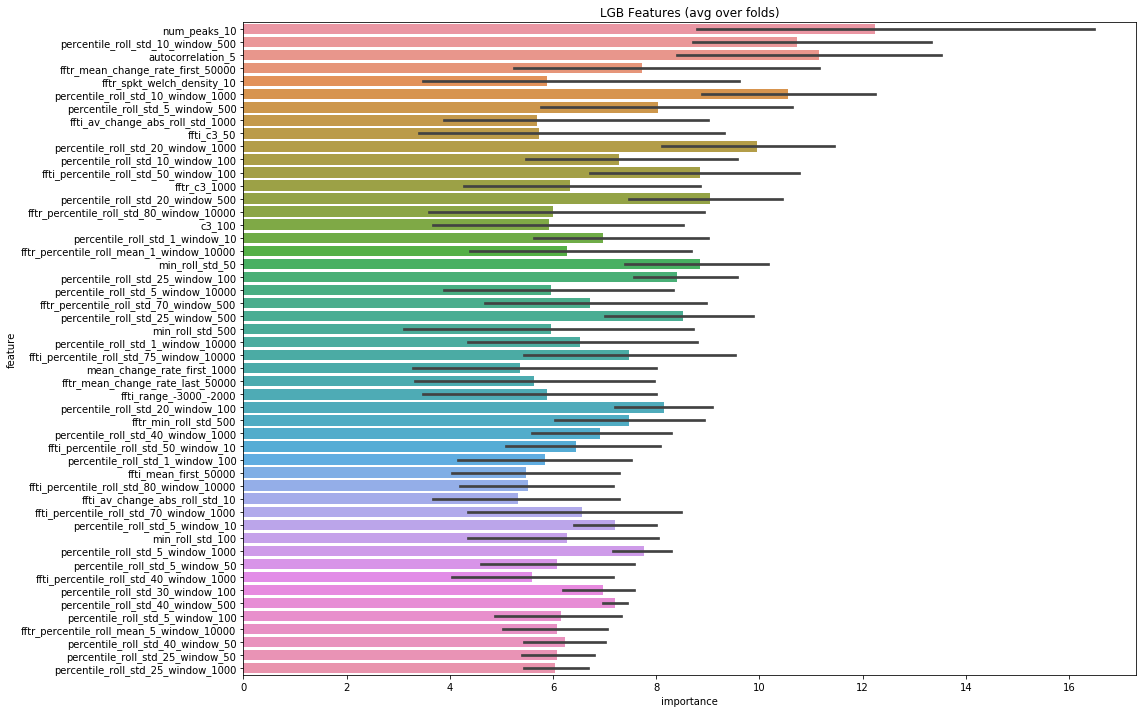

In [11]:
params = {'num_leaves': 128,
          'min_data_in_leaf': 79,
          'objective': 'gamma',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting": "gbdt",
          "bagging_freq": 5,
          "bagging_fraction": 0.8126672064208567,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1302650970728192,
          'reg_lambda': 0.3603427518866501,
          'feature_fraction': 0.1
         }
oof_lgb, prediction_lgb, feature_importance = train_model(X,
                                                          X_test,
                                                          y,
                                                          params=params,
                                                          model_type='lgb',
                                                          plot_feature_importance=True)

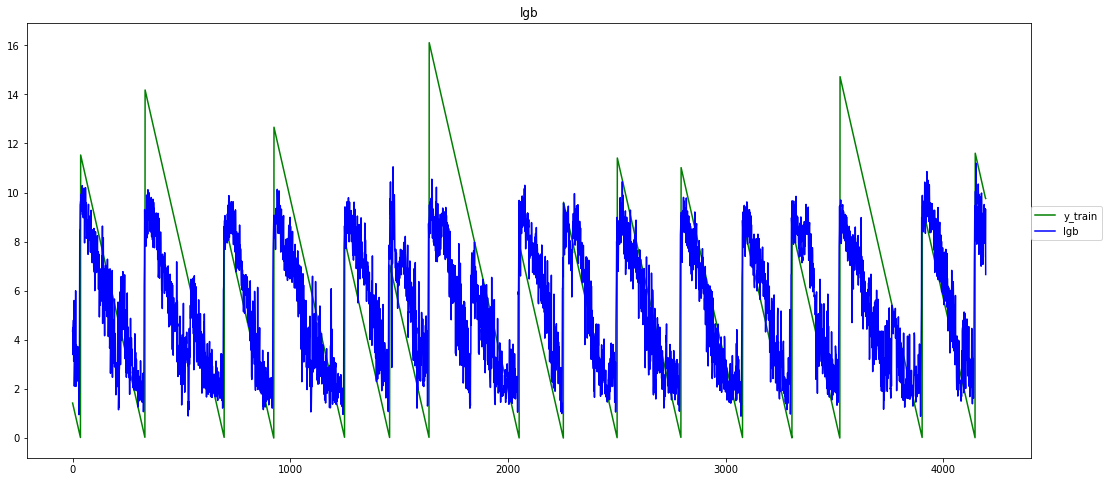

In [12]:
plt.figure(figsize=(18, 8))
plt.plot(y, color='g', label='y_train')
plt.plot(oof_lgb, color='b', label='lgb')
plt.legend(loc=(1, 0.5));
plt.title('lgb');

In [13]:
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
submission['time_to_failure'] = prediction_lgb
print(submission.head())
submission.to_csv('submission.csv')

              time_to_failure
seg_id                       
seg_00030f  2.873339564504676
seg_0012b5  4.627485054661275
seg_00184e  5.497832469779259
seg_003339  8.143064548290443
seg_0042cc  7.064758844352371


In [14]:
X.to_csv('train_features.csv', index=False)
X_test.to_csv('test_features.csv', index=False)
pd.DataFrame(y).to_csv('y.csv', index=False)